<a href="https://colab.research.google.com/github/yekcel/AI-Agent-MRI-Image-Defacing/blob/main/Multi_agnet_deface_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q ultralytics opencv-python google-generativeai pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.4 MB/s eta 0:00:00


In [18]:
import os
import cv2
import numpy as np
import google.generativeai as genai
from ultralytics import YOLO
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import json
from datetime import datetime


In [21]:
from google.colab import userdata

# Get API key from Colab secrets
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

# Configure Gemini
genai.configure(api_key=GEMINI_API_KEY)

# Initialize Gemini model
gemini_model = genai.GenerativeModel('gemini-2.0-flash-exp')

print("✅ Gemini API configured successfully!")


✅ Gemini API configured successfully!


In [22]:
# Create necessary directories
Path("input_images").mkdir(exist_ok=True)
Path("output_images").mkdir(exist_ok=True)
Path("logs").mkdir(exist_ok=True)

print("✅ Directories created:")
print("   • input_images/")
print("   • output_images/")
print("   • logs/")


✅ Directories created:
   • input_images/
   • output_images/
   • logs/


In [23]:
import requests

print("📥 Downloading YOLO face detection model...\n")

MODEL_URL = "https://github.com/yekcel/AI-Agent-MRI-Image-Defacing/raw/main/model_outputs/best_model.pt"
MODEL_PATH = "yolo_face_detector.pt"

try:
    response = requests.get(MODEL_URL, timeout=60)
    response.raise_for_status()

    with open(MODEL_PATH, 'wb') as f:
        f.write(response.content)

    file_size = os.path.getsize(MODEL_PATH)
    print(f"✅ Model downloaded successfully!")
    print(f"   Size: {file_size:,} bytes")
    print(f"   Path: {MODEL_PATH}")

except Exception as e:
    print(f"❌ Error downloading model: {str(e)}")


📥 Downloading YOLO face detection model...

✅ Model downloaded successfully!
   Size: 5,471,386 bytes
   Path: yolo_face_detector.pt


In [24]:
class DetectorAgent:
    """
    Agent responsible for detecting faces in MRI images using YOLO.
    """

    def __init__(self, model_path: str = "yolo_face_detector.pt", confidence: float = 0.3):
        """
        Initialize the detector agent.

        Args:
            model_path: Path to YOLO model weights
            confidence: Detection confidence threshold
        """
        self.model_path = model_path
        self.confidence = confidence
        self.model = None

    def load_model(self):
        """Load the YOLO model."""
        if self.model is None:
            self.model = YOLO(self.model_path)
            print(f"✅ DetectorAgent: Loaded YOLO model from {self.model_path}")

    def detect(self, image: np.ndarray) -> List[Dict]:
        """
        Detect faces in the image.

        Args:
            image: Grayscale MRI image

        Returns:
            List of detection dictionaries with bbox and confidence
        """
        self.load_model()

        # Convert grayscale to RGB for YOLO
        if len(image.shape) == 2:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            image_rgb = image

        # Run detection
        results = self.model(image_rgb, conf=self.confidence, verbose=False)

        detections = []
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            conf = box.conf[0].item()

            detections.append({
                'bbox': (x1, y1, x2, y2),
                'confidence': conf
            })

        return detections

print("✅ DetectorAgent class defined")


✅ DetectorAgent class defined


In [55]:
class DefacerAgent:
    """
    Agent responsible for applying various defacing strategies.
    """

    def __init__(self, shrink_factor: float = 0.15):
        """
        Initialize defacer agent.

        Args:
            shrink_factor: Percentage to shrink bounding box (0.15 = 15% smaller)
        """
        self.shrink_factor = shrink_factor

    def _shrink_bbox(self, bbox: Tuple[int, int, int, int],
                     image_shape: Tuple[int, int]) -> Tuple[int, int, int, int]:
        """
        Shrink bounding box to avoid brain tissue damage.

        Args:
            bbox: Original (x1, y1, x2, y2)
            image_shape: (height, width)

        Returns:
            Shrunk bounding box
        """
        x1, y1, x2, y2 = bbox
        h, w = image_shape

        # Calculate current dimensions
        width = x2 - x1
        height = y2 - y1

        # Calculate shrinking amount for each side
        shrink_x = int(width * self.shrink_factor / 2)
        shrink_y = int(height * self.shrink_factor / 2)

        # Apply shrinking
        new_x1 = max(0, x1 + shrink_x)
        new_y1 = max(0, y1 + shrink_y)
        new_x2 = min(w, x2 - shrink_x)
        new_y2 = min(h, y2 - shrink_y)

        return (new_x1, new_y1, new_x2, new_y2)

    def deface(self,
               image: np.ndarray,
               bbox: Tuple[int, int, int, int],
               strategy: str = 'moderate') -> np.ndarray:
        """
        Apply defacing strategy to detected face region.

        Args:
            image: Input grayscale image
            bbox: Bounding box (x1, y1, x2, y2)
            strategy: Defacing strategy to use

        Returns:
            Defaced image
        """
        result = image.copy()
        h, w = image.shape[:2]

        # Shrink bbox before applying strategy
        original_bbox = bbox
        bbox = self._shrink_bbox(bbox, (h, w))

        x1, y1, x2, y2 = bbox

        # Validate bbox
        if x2 <= x1 or y2 <= y1:
            print(f"   ⚠️  Invalid bbox after shrinking: {bbox}, skipping")
            return result

        print(f"   📏 Bbox: Original {original_bbox} → Shrunk {bbox} (factor={self.shrink_factor})")

        roi = image[y1:y2, x1:x2]

        if strategy == 'gentle':
            # Inpainting technique
            mask = np.ones(roi.shape, dtype=np.uint8) * 255
            defaced_roi = cv2.inpaint(roi, mask, 3, cv2.INPAINT_TELEA)
            result[y1:y2, x1:x2] = defaced_roi

        elif strategy == 'moderate':
            # Random texture fill
            mean_val = np.mean(roi)
            std_val = np.std(roi)
            noise = np.random.normal(mean_val, std_val * 0.3, roi.shape)
            result[y1:y2, x1:x2] = np.clip(noise, 0, 255).astype(np.uint8)

        elif strategy == 'maximum':
            # Black box masking
            result[y1:y2, x1:x2] = 0

        elif strategy == 'skull_strip':
            # Extended black box (expand upward toward skull)
            extend_up = int((y2 - y1) * 0.3)
            new_y1 = max(0, y1 - extend_up)
            result[new_y1:y2, x1:x2] = 0

        return result

print("✅ DefacerAgent class defined (with Mask Shrinking)")


✅ DefacerAgent class defined (with Mask Shrinking)


In [26]:
class ValidatorAgent:
    """
    Agent responsible for validating defaced images (ensuring no faces remain).
    """

    def __init__(self, model_path: str = "yolo_face_detector.pt", confidence: float = 0.1):
        """
        Initialize the validator agent.

        Args:
            model_path: Path to YOLO model weights
            confidence: Lower confidence threshold for validation
        """
        self.model_path = model_path
        self.confidence = confidence
        self.model = None

    def load_model(self):
        """Load the YOLO model."""
        if self.model is None:
            self.model = YOLO(self.model_path)
            print(f"✅ ValidatorAgent: Loaded YOLO model")

    def validate(self, image: np.ndarray, threshold: float = 0.3) -> Dict:
        """
        Validate that no faces remain in the defaced image.

        Args:
            image: Defaced grayscale MRI image
            threshold: Maximum acceptable confidence for remaining faces

        Returns:
            Validation result dictionary
        """
        self.load_model()

        # Convert grayscale to RGB for YOLO
        if len(image.shape) == 2:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            image_rgb = image

        # Run detection with lower confidence
        results = self.model(image_rgb, conf=self.confidence, verbose=False)

        detections = []
        max_confidence = 0.0

        for box in results[0].boxes:
            conf = box.conf[0].item()
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

            detections.append({
                'bbox': (x1, y1, x2, y2),
                'confidence': conf
            })

            max_confidence = max(max_confidence, conf)

        # Validation passes if no high-confidence faces remain
        is_valid = max_confidence < threshold

        return {
            'is_valid': is_valid,
            'detections': detections,
            'max_confidence': max_confidence,
            'num_faces': len(detections)
        }

print("✅ ValidatorAgent class defined")


✅ ValidatorAgent class defined


In [27]:
class GeminiStrategyAgent:
    """
    Agent that uses Gemini API to intelligently select defacing strategies.
    """

    def __init__(self, model):
        """
        Initialize the Gemini strategy agent.

        Args:
            model: Gemini generative model instance
        """
        self.model = model

    def decide_strategy(self, iteration: int, validation_result: Optional[Dict] = None,
                       previous_strategy: Optional[str] = None) -> str:
        """
        Use Gemini to decide the next defacing strategy.

        Args:
            iteration: Current iteration number (1-4)
            validation_result: Result from ValidatorAgent (None for first iteration)
            previous_strategy: Previously used strategy

        Returns:
            Strategy name: 'gentle', 'moderate', 'maximum', or 'skull_strip'
        """

        # Build prompt for Gemini
        if iteration == 1:
            prompt = """You are an AI agent helping to deface MRI images for privacy protection.
This is the FIRST attempt. Choose the best non-reversible defacing strategy from:
- gentle: Inpainting (subtle, tries to blend)
- moderate: Random texture fill (medium)
- maximum: Black box (complete removal)
- skull_strip: Extended removal towards skull

Choose ONE strategy. Respond with ONLY the strategy name."""

        else:
            max_conf = validation_result.get('max_confidence', 0.0)
            num_faces = validation_result.get('num_faces', 0)

            prompt = f"""You are an AI agent helping to deface MRI images for privacy protection.

ITERATION {iteration}/4
Previous strategy: {previous_strategy}
Validation result: {num_faces} faces detected, max confidence: {max_conf:.3f}

The previous strategy FAILED. Choose a MORE AGGRESSIVE non-reversible strategy from:
- gentle: Inpainting
- moderate: Random texture fill
- maximum: Black box
- skull_strip: Extended removal

IMPORTANT: Choose a strategy MORE AGGRESSIVE than '{previous_strategy}'.

Respond with ONLY the strategy name."""

        # Call Gemini
        response = self.model.generate_content(prompt)
        strategy = response.text.strip().lower()

        # Validate response
        valid_strategies = ['gentle', 'moderate', 'maximum', 'skull_strip']
        if strategy not in valid_strategies:
            # Fallback logic
            strategy_order = ['gentle', 'moderate', 'maximum', 'skull_strip']
            if previous_strategy and previous_strategy in strategy_order:
                idx = strategy_order.index(previous_strategy)
                strategy = strategy_order[min(idx + 1, len(strategy_order) - 1)]
            else:
                strategy = strategy_order[min(iteration - 1, len(strategy_order) - 1)]

        return strategy

print("✅ GeminiStrategyAgent class defined")


✅ GeminiStrategyAgent class defined


In [46]:
class RuleBasedStrategyAgent:
    """
    Rule-based strategy selector - no API needed!
    Uses deterministic rules based on iteration and validation results.
    """

    def __init__(self):
        # Define strategy escalation path
        self.strategy_ladder = ['gentle', 'moderate', 'maximum', 'skull_strip']

    def decide_strategy(self,
                       iteration: int,
                       validation_result: Optional[Dict] = None,
                       previous_strategy: Optional[str] = None) -> str:
        """
        Decide defacing strategy based on rules.

        Strategy Logic:
        - Iteration 1: Start with 'gentle'
        - If validation fails: Escalate to next aggressive level
        - If max confidence is high (>0.5): Jump directly to 'maximum'
        - Last iteration: Always use 'skull_strip'

        Args:
            iteration: Current iteration number (1-4)
            validation_result: Result from previous validation
            previous_strategy: Previously used strategy

        Returns:
            Selected strategy name
        """
        # Rule 1: First iteration - start gentle
        if iteration == 1:
            selected = 'gentle'
            print(f"   🎯 Rule Applied: First iteration → Start with '{selected}'")
            return selected

        # Rule 2: Last iteration - go nuclear
        if iteration == 4:
            selected = 'skull_strip'
            print(f"   🎯 Rule Applied: Final iteration → Maximum aggression '{selected}'")
            return selected

        # Rule 3: High confidence detected - escalate immediately
        if validation_result and validation_result['max_confidence'] > 0.5:
            selected = 'maximum'
            print(f"   🎯 Rule Applied: High confidence ({validation_result['max_confidence']:.3f}) → Jump to '{selected}'")
            return selected

        # Rule 4: Progressive escalation
        if previous_strategy:
            try:
                current_index = self.strategy_ladder.index(previous_strategy)
                next_index = min(current_index + 1, len(self.strategy_ladder) - 1)
                selected = self.strategy_ladder[next_index]
                print(f"   🎯 Rule Applied: Escalate from '{previous_strategy}' → '{selected}'")
                return selected
            except ValueError:
                pass

        # Rule 5: Default fallback based on iteration
        strategy_map = {
            2: 'moderate',
            3: 'maximum'
        }
        selected = strategy_map.get(iteration, 'moderate')
        print(f"   🎯 Rule Applied: Iteration {iteration} → Default to '{selected}'")
        return sel

print("✅ RuleBasedStrategyAgent class defined")


✅ RuleBasedStrategyAgent class defined


In [47]:
class MultiAgentOrchestrator:
    """
    Orchestrator that coordinates all agents in the defacing pipeline.
    """

    def __init__(self, max_iterations: int = 4, validation_threshold: float = 0.3, use_gemini: bool = False):
        """
        Initialize the orchestrator.

        Args:
            max_iterations: Maximum number of defacing attempts
            validation_threshold: Confidence threshold for validation
            use_gemini: Use Gemini API (if False, uses rule-based strategy)
        """
        self.detector = DetectorAgent()
        self.defacer = DefacerAgent()
        self.validator = ValidatorAgent()

        # Choose strategy agent
        if use_gemini:
            self.strategy_agent = GeminiStrategyAgent(gemini_model)
            print("🧠 Using Gemini API for strategy selection")
        else:
            self.strategy_agent = RuleBasedStrategyAgent()
            print("🤖 Using Rule-Based strategy selection")

        self.max_iterations = max_iterations
        self.validation_threshold = validation_threshold

    def run(self, image_path: str) -> Dict:
        """
        Run the complete multi-agent defacing pipeline.

        Args:
            image_path: Path to input MRI image

        Returns:
            Result dictionary with status, defaced image, and metadata
        """
        print(f"\n{'='*60}")
        print(f"🚀 Starting Multi-Agent Defacing Pipeline")
        print(f"{'='*60}\n")

        # Load image
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original_image is None:
            return {'status': 'error', 'message': 'Failed to load image'}

        print(f"📸 Image loaded: {original_image.shape}")

        # Step 1: Initial Detection
        print(f"\n🔍 Step 1: Initial Face Detection")
        detections = self.detector.detect(original_image)

        if not detections:
            print("   ℹ️  No faces detected - image is already defaced/clean")
            return {
                'status': 'no_faces',
                'defaced_image': original_image,
                'iterations': 0,
                'strategies_used': []
            }

        print(f"   ✅ Detected {len(detections)} face(s)")
        for i, det in enumerate(detections, 1):
            print(f"      Face {i}: confidence={det['confidence']:.3f}, bbox={det['bbox']}")

        # Iterative defacing loop
        current_image = original_image.copy()
        strategies_used = []
        previous_strategy = None
        validation_result = None

        for iteration in range(1, self.max_iterations + 1):
            print(f"\n{'─'*60}")
            print(f"🔄 Iteration {iteration}/{self.max_iterations}")
            print(f"{'─'*60}")

            # Step 2: Gemini decides strategy
            print(f"\n🧠 Step 2: Gemini Strategy Selection")
            strategy = self.strategy_agent.decide_strategy(
                iteration=iteration,
                validation_result=validation_result,
                previous_strategy=previous_strategy
            )
            print(f"   📋 Selected strategy: '{strategy}'")
            strategies_used.append(strategy)

            # Step 3: Apply defacing
            print(f"\n✂️  Step 3: Applying Defacing")
            for det in detections:
                current_image = self.defacer.deface(
                    current_image,
                    det['bbox'],
                    strategy=strategy
                )
            print(f"   ✅ Defacing applied with '{strategy}' strategy")

            # Step 4: Validate result
            print(f"\n✔️  Step 4: Validation")
            validation_result = self.validator.validate(
                current_image,
                threshold=self.validation_threshold  # ✅ threshold رو اینجا پاس می‌دیم
            )

            print(f"   Faces detected: {validation_result['num_faces']}")
            print(f"   Max confidence: {validation_result['max_confidence']:.3f}")
            print(f"   Threshold: {self.validation_threshold}")

            if validation_result['is_valid']:
                print(f"   ✅ Validation PASSED!")
                print(f"\n{'='*60}")
                print(f"✅ SUCCESS - Image successfully defaced in {iteration} iteration(s)")
                print(f"{'='*60}")
                return {
                    'status': 'success',
                    'defaced_image': current_image,
                    'iterations': iteration,
                    'strategies_used': strategies_used,
                    'final_confidence': validation_result['max_confidence']
                }
            else:
                print(f"   ❌ Validation FAILED - trying next iteration")

            previous_strategy = strategy

        # Max iterations reached
        print(f"\n{'='*60}")
        print(f"⚠️  MAX ITERATIONS REACHED - Image may not be fully defaced")
        print(f"{'='*60}")
        return {
            'status': 'max_iterations',
            'defaced_image': current_image,
            'iterations': self.max_iterations,
            'strategies_used': strategies_used,
            'final_confidence': validation_result['max_confidence']
        }

print("✅ MultiAgentOrchestrator class defined")


✅ MultiAgentOrchestrator class defined


In [48]:
import requests
from pathlib import Path

print("📥 Downloading test MRI images from GitHub...")

# Create input folder
Path("input_images").mkdir(exist_ok=True)

# Correct RAW URLs for test images
TEST_IMAGE_URLS = [
    "https://github.com/yekcel/AI-Agent-MRI-Image-Defacing/raw/main/test_data/images/dicom_000209_jpg.rf.68d7b19c0c5017332d18516147668c4f.jpg",
    "https://github.com/yekcel/AI-Agent-MRI-Image-Defacing/raw/main/test_data/images/dicom_000218_jpg.rf.2d70d50536d38f2bfa4bd4699955db8b.jpg",
    "https://github.com/yekcel/AI-Agent-MRI-Image-Defacing/raw/main/test_data/images/dicom_002284_jpg.rf.0ef17c3c1c6d85b222e00e3ec887c8ce.jpg",
]

success_count = 0

for idx, url in enumerate(TEST_IMAGE_URLS, 1):
    filename = url.split('/')[-1]
    print(f"   [{idx}/{len(TEST_IMAGE_URLS)}] Downloading {filename[:50]}...")

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()

        # Save file
        save_path = f"input_images/{filename}"
        with open(save_path, 'wb') as f:
            f.write(response.content)

        file_size = len(response.content)
        print(f"      ✅ Saved ({file_size:,} bytes)")
        success_count += 1

    except Exception as e:
        print(f"      ❌ Error: {str(e)}")

print(f"\n✅ Successfully downloaded {success_count}/{len(TEST_IMAGE_URLS)} images!")

# List downloaded images
files = os.listdir("input_images")
if files:
    print(f"\n📁 Files in input_images/:")
    for f in files:
        size = os.path.getsize(f"input_images/{f}")
        print(f"   • {f[:50]} ({size:,} bytes)")


📥 Downloading test MRI images from GitHub...
   [1/3] Downloading dicom_000209_jpg.rf.68d7b19c0c5017332d18516147668c...
      ✅ Saved (26,364 bytes)
   [2/3] Downloading dicom_000218_jpg.rf.2d70d50536d38f2bfa4bd4699955db...
      ✅ Saved (24,814 bytes)
   [3/3] Downloading dicom_002284_jpg.rf.0ef17c3c1c6d85b222e00e3ec887c8...
      ✅ Saved (21,033 bytes)

✅ Successfully downloaded 3/3 images!

📁 Files in input_images/:
   • dicom_000209_jpg.rf.68d7b19c0c5017332d18516147668c (26,364 bytes)
   • dicom_000218_jpg.rf.2d70d50536d38f2bfa4bd4699955db (24,814 bytes)
   • dicom_002284_jpg.rf.0ef17c3c1c6d85b222e00e3ec887c8 (21,033 bytes)


In [49]:
from ultralytics import YOLO
import cv2
import os

print("🧪 Testing YOLO model on downloaded images...\n")

model = YOLO("yolo_face_detector.pt")

# Get first image
images = [f for f in os.listdir("input_images") if f.endswith(('.jpg', '.png', '.jpeg'))]

if not images:
    print("❌ No images found in input_images/")
else:
    test_image_path = f"input_images/{images[0]}"
    print(f"Testing on: {images[0]}")

    # Load image as grayscale
    img_gray = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

    if img_gray is None:
        print("❌ Failed to load image!")
    else:
        print(f"   ✅ Image loaded: {img_gray.shape} (grayscale)")

        # Convert grayscale to RGB (YOLO needs 3 channels)
        img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
        print(f"   🔄 Converted to RGB: {img_rgb.shape}")

        # Run detection
        results = model(img_rgb, conf=0.3, verbose=False)

        if len(results[0].boxes) > 0:
            print(f"   ✅ Detected {len(results[0].boxes)} face(s)")
            for i, box in enumerate(results[0].boxes, 1):
                conf = box.conf[0].item()
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                print(f"      Face {i}: confidence={conf:.3f}, bbox=({x1},{y1},{x2},{y2})")
        else:
            print("   ⚠️  No faces detected")
            print("      Try lowering confidence threshold")


🧪 Testing YOLO model on downloaded images...

Testing on: dicom_000209_jpg.rf.68d7b19c0c5017332d18516147668c4f.jpg
   ✅ Image loaded: (512, 512) (grayscale)
   🔄 Converted to RGB: (512, 512, 3)
   ✅ Detected 1 face(s)
      Face 1: confidence=0.689, bbox=(41,210,173,415)


In [56]:
# Initialize orchestrator (WITHOUT Gemini)
orchestrator = MultiAgentOrchestrator(
    max_iterations=4,
    validation_threshold=0.3,
    use_gemini=False  # deactive Gemini
)

🤖 Using Rule-Based strategy selection


In [57]:
import os
from pathlib import Path

# Get list of input images
input_images = sorted([f for f in os.listdir("input_images")
                       if f.endswith(('.jpg', '.png', '.jpeg'))])

if not input_images:
    print("❌ No images found in input_images/ folder!")
else:
    # Process first image as test
    test_image = input_images[0]
    test_path = f"input_images/{test_image}"

    print(f"🎯 Processing test image: {test_image}\n")

    result = orchestrator.run(test_path)

    # Save result
    if 'defaced_image' in result:
        output_path = f"output_images/defaced_{test_image}"
        cv2.imwrite(output_path, result['defaced_image'])
        print(f"\n💾 Saved to: {output_path}")

    # Print summary
    print(f"\n{'='*60}")
    print("📊 PROCESSING SUMMARY")
    print(f"{'='*60}")
    print(f"Status: {result['status']}")
    print(f"Iterations: {result.get('iterations', 0)}")
    print(f"Strategies used: {' → '.join(result.get('strategies_used', []))}")
    if 'final_confidence' in result:
        print(f"Final confidence: {result['final_confidence']:.3f}")
    print(f"{'='*60}")


🎯 Processing test image: dicom_000209_jpg.rf.68d7b19c0c5017332d18516147668c4f.jpg


🚀 Starting Multi-Agent Defacing Pipeline

📸 Image loaded: (512, 512)

🔍 Step 1: Initial Face Detection
✅ DetectorAgent: Loaded YOLO model from yolo_face_detector.pt
   ✅ Detected 1 face(s)
      Face 1: confidence=0.689, bbox=(41, 210, 173, 415)

────────────────────────────────────────────────────────────
🔄 Iteration 1/4
────────────────────────────────────────────────────────────

🧠 Step 2: Gemini Strategy Selection
   🎯 Rule Applied: First iteration → Start with 'gentle'
   📋 Selected strategy: 'gentle'

✂️  Step 3: Applying Defacing
   📏 Bbox: Original (41, 210, 173, 415) → Shrunk (50, 225, 164, 400) (factor=0.15)
   ✅ Defacing applied with 'gentle' strategy

✔️  Step 4: Validation
✅ ValidatorAgent: Loaded YOLO model
   Faces detected: 1
   Max confidence: 0.689
   Threshold: 0.3
   ❌ Validation FAILED - trying next iteration

────────────────────────────────────────────────────────────
🔄 Iteration 

In [58]:
import os
from pathlib import Path
import cv2

# Get all input images
input_images = sorted([f for f in os.listdir("input_images")
                       if f.endswith(('.jpg', '.png', '.jpeg'))])

if not input_images:
    print("❌ No images to process!")
else:
    print(f"🚀 Processing {len(input_images)} images in batch mode...\n")

    results_summary = []

    for idx, filename in enumerate(input_images, 1):
        input_path = f"input_images/{filename}"

        print(f"\n{'='*60}")
        print(f"📸 Image {idx}/{len(input_images)}: {filename}")
        print(f"{'='*60}")

        result = orchestrator.run(input_path)

        # Save defaced image
        if 'defaced_image' in result:
            output_path = f"output_images/defaced_{filename}"
            cv2.imwrite(output_path, result['defaced_image'])
            print(f"💾 Saved: {output_path}")

        # Store summary
        results_summary.append({
            'filename': filename,
            'status': result['status'],
            'iterations': result.get('iterations', 0),
            'strategies': ' → '.join(result.get('strategies_used', [])),
            'final_conf': result.get('final_confidence', 0.0)
        })

    # Print overall summary
    print(f"\n{'='*60}")
    print("🎯 BATCH PROCESSING COMPLETE")
    print(f"{'='*60}\n")

    for r in results_summary:
        status_icon = "✅" if r['status'] == 'success' else "⚠️"
        print(f"{status_icon} {r['filename'][:50]}")
        print(f"   Iterations: {r['iterations']}, Strategies: {r['strategies']}")
        print(f"   Final confidence: {r['final_conf']:.3f}\n")


🚀 Processing 3 images in batch mode...


📸 Image 1/3: dicom_000209_jpg.rf.68d7b19c0c5017332d18516147668c4f.jpg

🚀 Starting Multi-Agent Defacing Pipeline

📸 Image loaded: (512, 512)

🔍 Step 1: Initial Face Detection
   ✅ Detected 1 face(s)
      Face 1: confidence=0.689, bbox=(41, 210, 173, 415)

────────────────────────────────────────────────────────────
🔄 Iteration 1/4
────────────────────────────────────────────────────────────

🧠 Step 2: Gemini Strategy Selection
   🎯 Rule Applied: First iteration → Start with 'gentle'
   📋 Selected strategy: 'gentle'

✂️  Step 3: Applying Defacing
   📏 Bbox: Original (41, 210, 173, 415) → Shrunk (50, 225, 164, 400) (factor=0.15)
   ✅ Defacing applied with 'gentle' strategy

✔️  Step 4: Validation
   Faces detected: 1
   Max confidence: 0.689
   Threshold: 0.3
   ❌ Validation FAILED - trying next iteration

────────────────────────────────────────────────────────────
🔄 Iteration 2/4
────────────────────────────────────────────────────────────

🧠 St

📊 Visualizing before/after comparisons...



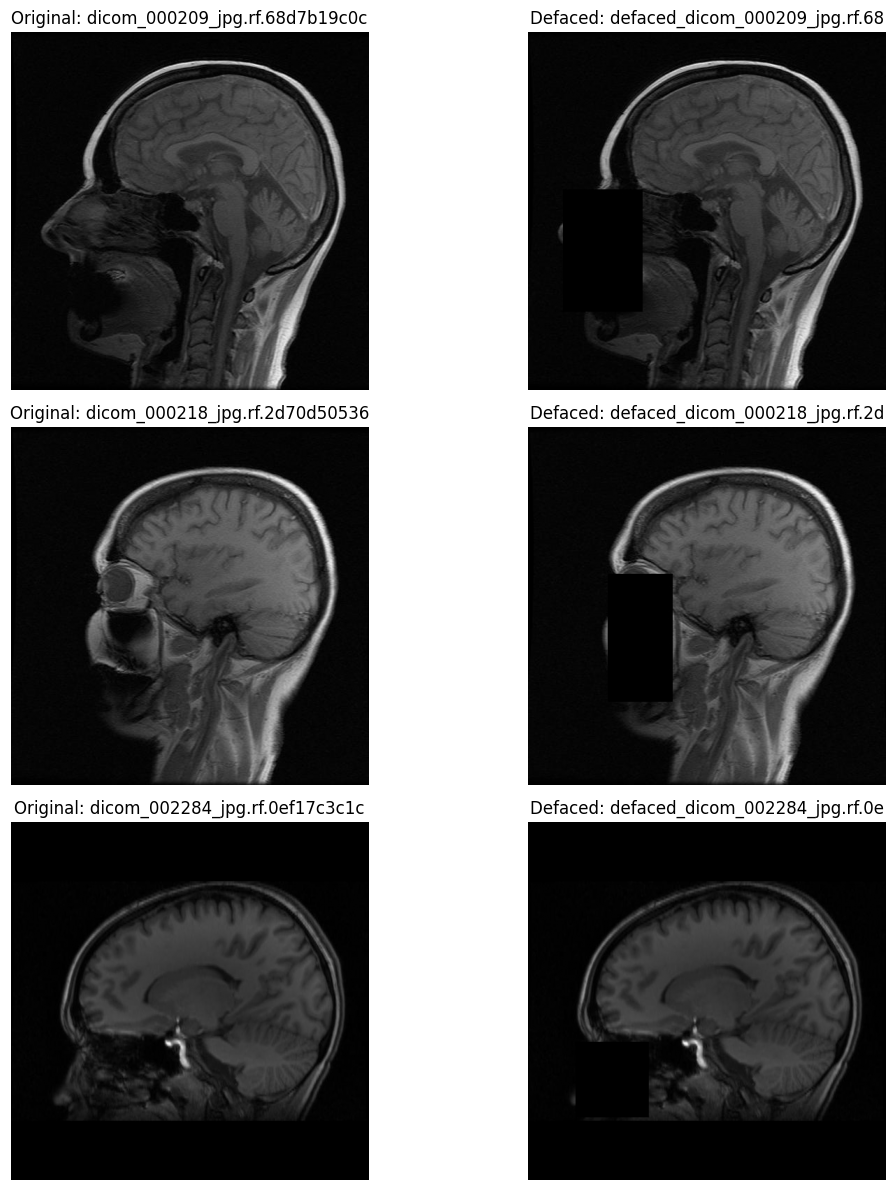

✅ Visualization complete!


In [59]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

print("📊 Visualizing before/after comparisons...\n")

# Get matching pairs
input_files = sorted([f for f in os.listdir("input_images") if f.endswith('.jpg')])
output_files = [f"defaced_{f}" for f in input_files]

# Show first 3 pairs
num_to_show = min(3, len(input_files))

fig, axes = plt.subplots(num_to_show, 2, figsize=(12, 4*num_to_show))
if num_to_show == 1:
    axes = axes.reshape(1, -1)

for idx in range(num_to_show):
    # Load images
    original = cv2.imread(f"input_images/{input_files[idx]}", cv2.IMREAD_GRAYSCALE)
    defaced = cv2.imread(f"output_images/{output_files[idx]}", cv2.IMREAD_GRAYSCALE)

    # Plot
    axes[idx, 0].imshow(original, cmap='gray')
    axes[idx, 0].set_title(f"Original: {input_files[idx][:30]}")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(defaced, cmap='gray')
    axes[idx, 1].set_title(f"Defaced: {output_files[idx][:30]}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")


In [60]:
import shutil
from datetime import datetime

# Create ZIP file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"defaced_mri_results_{timestamp}"

print(f"📦 Creating ZIP archive: {zip_filename}.zip")

shutil.make_archive(zip_filename, 'zip', 'output_images')

print(f"✅ Archive created: {zip_filename}.zip")
print(f"\n💾 Download it from the Colab file browser (left sidebar)")


📦 Creating ZIP archive: defaced_mri_results_20260103_214628.zip
✅ Archive created: defaced_mri_results_20260103_214628.zip

💾 Download it from the Colab file browser (left sidebar)
